# Generating Mood Playlists

## Framing the Problem

### Business Objective

We would like to improve our approach to recommending music to our users and making better quality playlists that fit a user's different moods. In the long run, we want to do so to increase product value and retain users and market share. This is quite important as we are going against Apple Music, a competiting product that has a considerable portion of market share. 

### The Model

To improve our recommendation system and increasing product value, we have to try to understand what is the relationship between a user's mood and a song's audio features. This field of study is called music emotion recognition (MER) and there has been studies in the past that map this relationship through theoretical models. By applying these models and audio features of different songs to machine learning, we try to find mood structure and patterns within the songs. We will use a Gaussian Mixture Model (GMM) clustering approach to do so and analyze the results to label the dataset. 

After labeling the dataset, we will test out 3 different models to classify the dataset based on the mood it evokes. These models are Random Forest, K-Nearest Neighbors and Gradient Boosting. 

### Performance Assessment

There is no way of measuring the performance of our labeling efforts, but we will analyze the result and compare it according to theoretical studies to validate our results in a non-technical manner. 

As for our models used to classify the dataset, we'll be using the F1-score and the area under the precision-recall curve as we would like to classify as many songs by their correct mood as possible to minimize inaccuracy of mood class assignment.

### Assumptions

GMM clustering assumes that the data is of a Gaussian mixture distribution and each song are independent from each other. 

K-Nearest Neighbors assumes that each feature is of equal importance. Thus, it is important to perform feature selection as to not have any redundant features.

Both random forest and gradient boosting are non-parametric models and thus assume nothing. 

Resource: https://www.kdnuggets.com/2021/02/machine-learning-assumptions.html

In [1]:
# imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# allowing all the columns to be visualized
pd.options.display.max_columns = None

# rendering all graphics straight out of the notebook
%matplotlib inline

import warnings
warnings.filterwarnings(action='once')

In [2]:
# visualizations settings
sns.set_theme(style = "whitegrid", font_scale = 1.5)
qual_pal = sns.color_palette('hls', 8)

## Exploring the Dataset

### Why is it important to explore the dataset?
This step is important because it helps us identify patterns and problems in the dataset. More importantly, it **helps us decide what models or algorithms to use in subsequent steps**. REMEMBER: **GARBAGE IN, GARBAGE OUT!**

### Data Exploration Plan
1. Identify and deal with outliers in data
Outliers–observations that have extremely large or small values relative to the majority of observations–can have great impact on results. Not identifying and dealing with them can lead to inaccurate outputs. Boxplots, histograms, violin plots, scatterplots, biplots can be used to detect outliers. 

2. Checking for homogeneity in variances
This is an important assumption in ANOVA, multivariate techniques and regression-based models. 

3. Checking for normally distributed data

4. Checking for missing values in data

5. Checking for multicollinearity (collinearity in covariates)

6. Checking for interaction between variables

7. Checking for independence in data

In [3]:
# importing in main dataset (audio features, genre, track id)
audio_features = pd.read_csv('/Users/huongngo/Desktop/PERSONAL PROJECTS/music_explorer/data/audio_features.csv')
audio_features = audio_features.drop(['Unnamed: 0'], axis = 1)
audio_features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,explicit,artist_name,track_popularity
0,0.492,0.791,11,-5.045,1,0.0703,0.00816,0.000019,0.110,0.585,144.363,audio_features,0LJIVYOer8mlCmTrKoP9Kh,spotify:track:0LJIVYOer8mlCmTrKoP9Kh,https://api.spotify.com/v1/tracks/0LJIVYOer8ml...,https://api.spotify.com/v1/audio-analysis/0LJI...,218391,4,jazz,False,Michael Bublé,54
1,0.278,0.354,5,-6.647,0,0.0372,0.50200,0.001240,0.309,0.090,121.803,audio_features,3xZFuVIvzqBImEYJydRkp9,spotify:track:3xZFuVIvzqBImEYJydRkp9,https://api.spotify.com/v1/tracks/3xZFuVIvzqBI...,https://api.spotify.com/v1/audio-analysis/3xZF...,208866,3,jazz,False,Michael Bublé,47
2,0.509,0.457,6,-6.021,1,0.0381,0.39800,0.000000,0.104,0.521,116.472,audio_features,1ugWQPtI7SNYDXqEwuEjVm,spotify:track:1ugWQPtI7SNYDXqEwuEjVm,https://api.spotify.com/v1/tracks/1ugWQPtI7SNY...,https://api.spotify.com/v1/audio-analysis/1ugW...,185531,4,jazz,False,Michael Bublé,52
3,0.401,0.712,8,-4.518,1,0.0300,0.03710,0.001890,0.091,0.561,84.343,audio_features,4BECSdUBaiMX0dNmLHr0kZ,spotify:track:4BECSdUBaiMX0dNmLHr0kZ,https://api.spotify.com/v1/tracks/4BECSdUBaiMX...,https://api.spotify.com/v1/audio-analysis/4BEC...,197755,4,jazz,False,Michael Bublé,53
4,0.506,0.612,11,-6.297,1,0.0607,0.03010,0.000000,0.116,0.527,139.931,audio_features,7zqznhNk8DZbwo8fWIF82V,spotify:track:7zqznhNk8DZbwo8fWIF82V,https://api.spotify.com/v1/tracks/7zqznhNk8DZb...,https://api.spotify.com/v1/audio-analysis/7zqz...,143386,3,jazz,False,Michael Bublé,51


In [4]:
spec_type = ['NU', 'NU', 'NO', 'NU', 'NO', 'NU', 'NU', 'NU', 'NU', 'NU', 'NU', 'STR', 'STR', 'STR', 'STR', 'STR', 'NU', 'NO', 'NO', 'NO', 'STR', 'NU']
data_type = pd.DataFrame(audio_features.dtypes, columns = ['Data Type'])
data_type['Specific Data Type'] = spec_type
data_type.sort_values(by = ['Specific Data Type'])

,Data Type,Specific Data Type
explicit,bool,NO
key,int64,NO
genre,object,NO
mode,int64,NO
time_signature,int64,NO
danceability,float64,NU
duration_ms,int64,NU
valence,float64,NU
tempo,float64,NU
instrumentalness,float64,NU


In [5]:
audio_features['explicit'] = audio_features['explicit'].map({True: 'True', False: 'False'}) 

In [6]:
numeric_columns = list(audio_features.columns[:11]) + list(audio_features.columns[16:18]) + [audio_features.columns[-1]]
string_columns = list(audio_features.columns[11:16]) + list(audio_features.columns[18:20]) + [audio_features.columns[-2]]

In [7]:
# dataset info
audio_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52897 entries, 0 to 52896
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      52897 non-null  float64
 1   energy            52897 non-null  float64
 2   key               52897 non-null  int64  
 3   loudness          52897 non-null  float64
 4   mode              52897 non-null  int64  
 5   speechiness       52897 non-null  float64
 6   acousticness      52897 non-null  float64
 7   instrumentalness  52897 non-null  float64
 8   liveness          52897 non-null  float64
 9   valence           52897 non-null  float64
 10  tempo             52897 non-null  float64
 11  type              52897 non-null  object 
 12  id                52897 non-null  object 
 13  uri               52897 non-null  object 
 14  track_href        52897 non-null  object 
 15  analysis_url      52897 non-null  object 
 16  duration_ms       52897 non-null  int64 

In [8]:
# descriptive statistics about data
audio_features[numeric_columns].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity
count,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000,5.289700e+04,52897.000000,52897.000000
mean,0.545858,0.593354,5.248804,-9.254906,0.639186,0.094807,0.340417,0.165000,0.229081,0.456094,118.815043,2.313948e+05,3.890221,26.845322
std,0.181316,0.265136,3.606166,5.813155,0.480241,0.125607,0.351263,0.317771,0.213840,0.257094,30.561409,1.232451e+05,0.474021,20.096229
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.339000e+03,0.000000,0.000000
25%,0.420000,0.405000,2.000000,-11.180000,0.000000,0.036000,0.026500,0.000000,0.099000,0.242000,95.003000,1.786270e+05,4.000000,10.000000
50%,0.556000,0.634000,5.000000,-7.608000,1.000000,0.049300,0.186000,0.000104,0.133000,0.442000,117.788000,2.175060e+05,4.000000,25.000000
75%,0.684000,0.814000,8.000000,-5.349000,1.000000,0.093000,0.654000,0.072900,0.288000,0.657000,138.294000,2.661720e+05,4.000000,41.000000
max,0.989000,1.000000,11.000000,0.229000,1.000000,0.965000,0.996000,1.000000,0.999000,0.986000,248.060000,4.497994e+06,5.000000,97.000000


Loudness, acousticness, liveness, duration columns don't seem to be very useful in determining moods. 

Instrumentalness and speechiness seems to be similar features, so we might have to select either one of them, or none of them if they prove to not be useful in determining mood. 

Both tempo and time signature refer to rhythm of the music. We might choose either one of them. 

Mode can be derived from key, but is more easily explained and captures the general idea of keys. Thus, we will select mode between them. 

Track popularity is completely unrelated to mood. 

This leaves the following columns that are potentially good features to keep for clustering: danceability, energy, mode, valence, tempo. 

In [9]:
# converting duration_ms to duration_s (milliseconds to seconds) to fix scale
audio_features['duration_s'] = audio_features['duration_ms'] * 0.001
print(audio_features.columns)
audio_features = audio_features.drop(['duration_ms'], axis = 1)
print(audio_features.columns)

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre', 'explicit', 'artist_name',
       'track_popularity', 'duration_s'],
      dtype='object')
Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'time_signature',
       'genre', 'explicit', 'artist_name', 'track_popularity', 'duration_s'],
      dtype='object')


In [10]:
key_cnt = audio_features.groupby(['key']).count()
key_cnt = pd.DataFrame(key_cnt['id'])

ts_cnt = audio_features.groupby(['time_signature']).count()
ts_cnt = pd.DataFrame(ts_cnt['id'])

mode_cnt = audio_features.groupby(['mode']).count()
mode_cnt = pd.DataFrame(mode_cnt['id'])

exp_cnt = audio_features.groupby(['explicit']).count()
exp_cnt = pd.DataFrame(exp_cnt['id'])

[None, None]

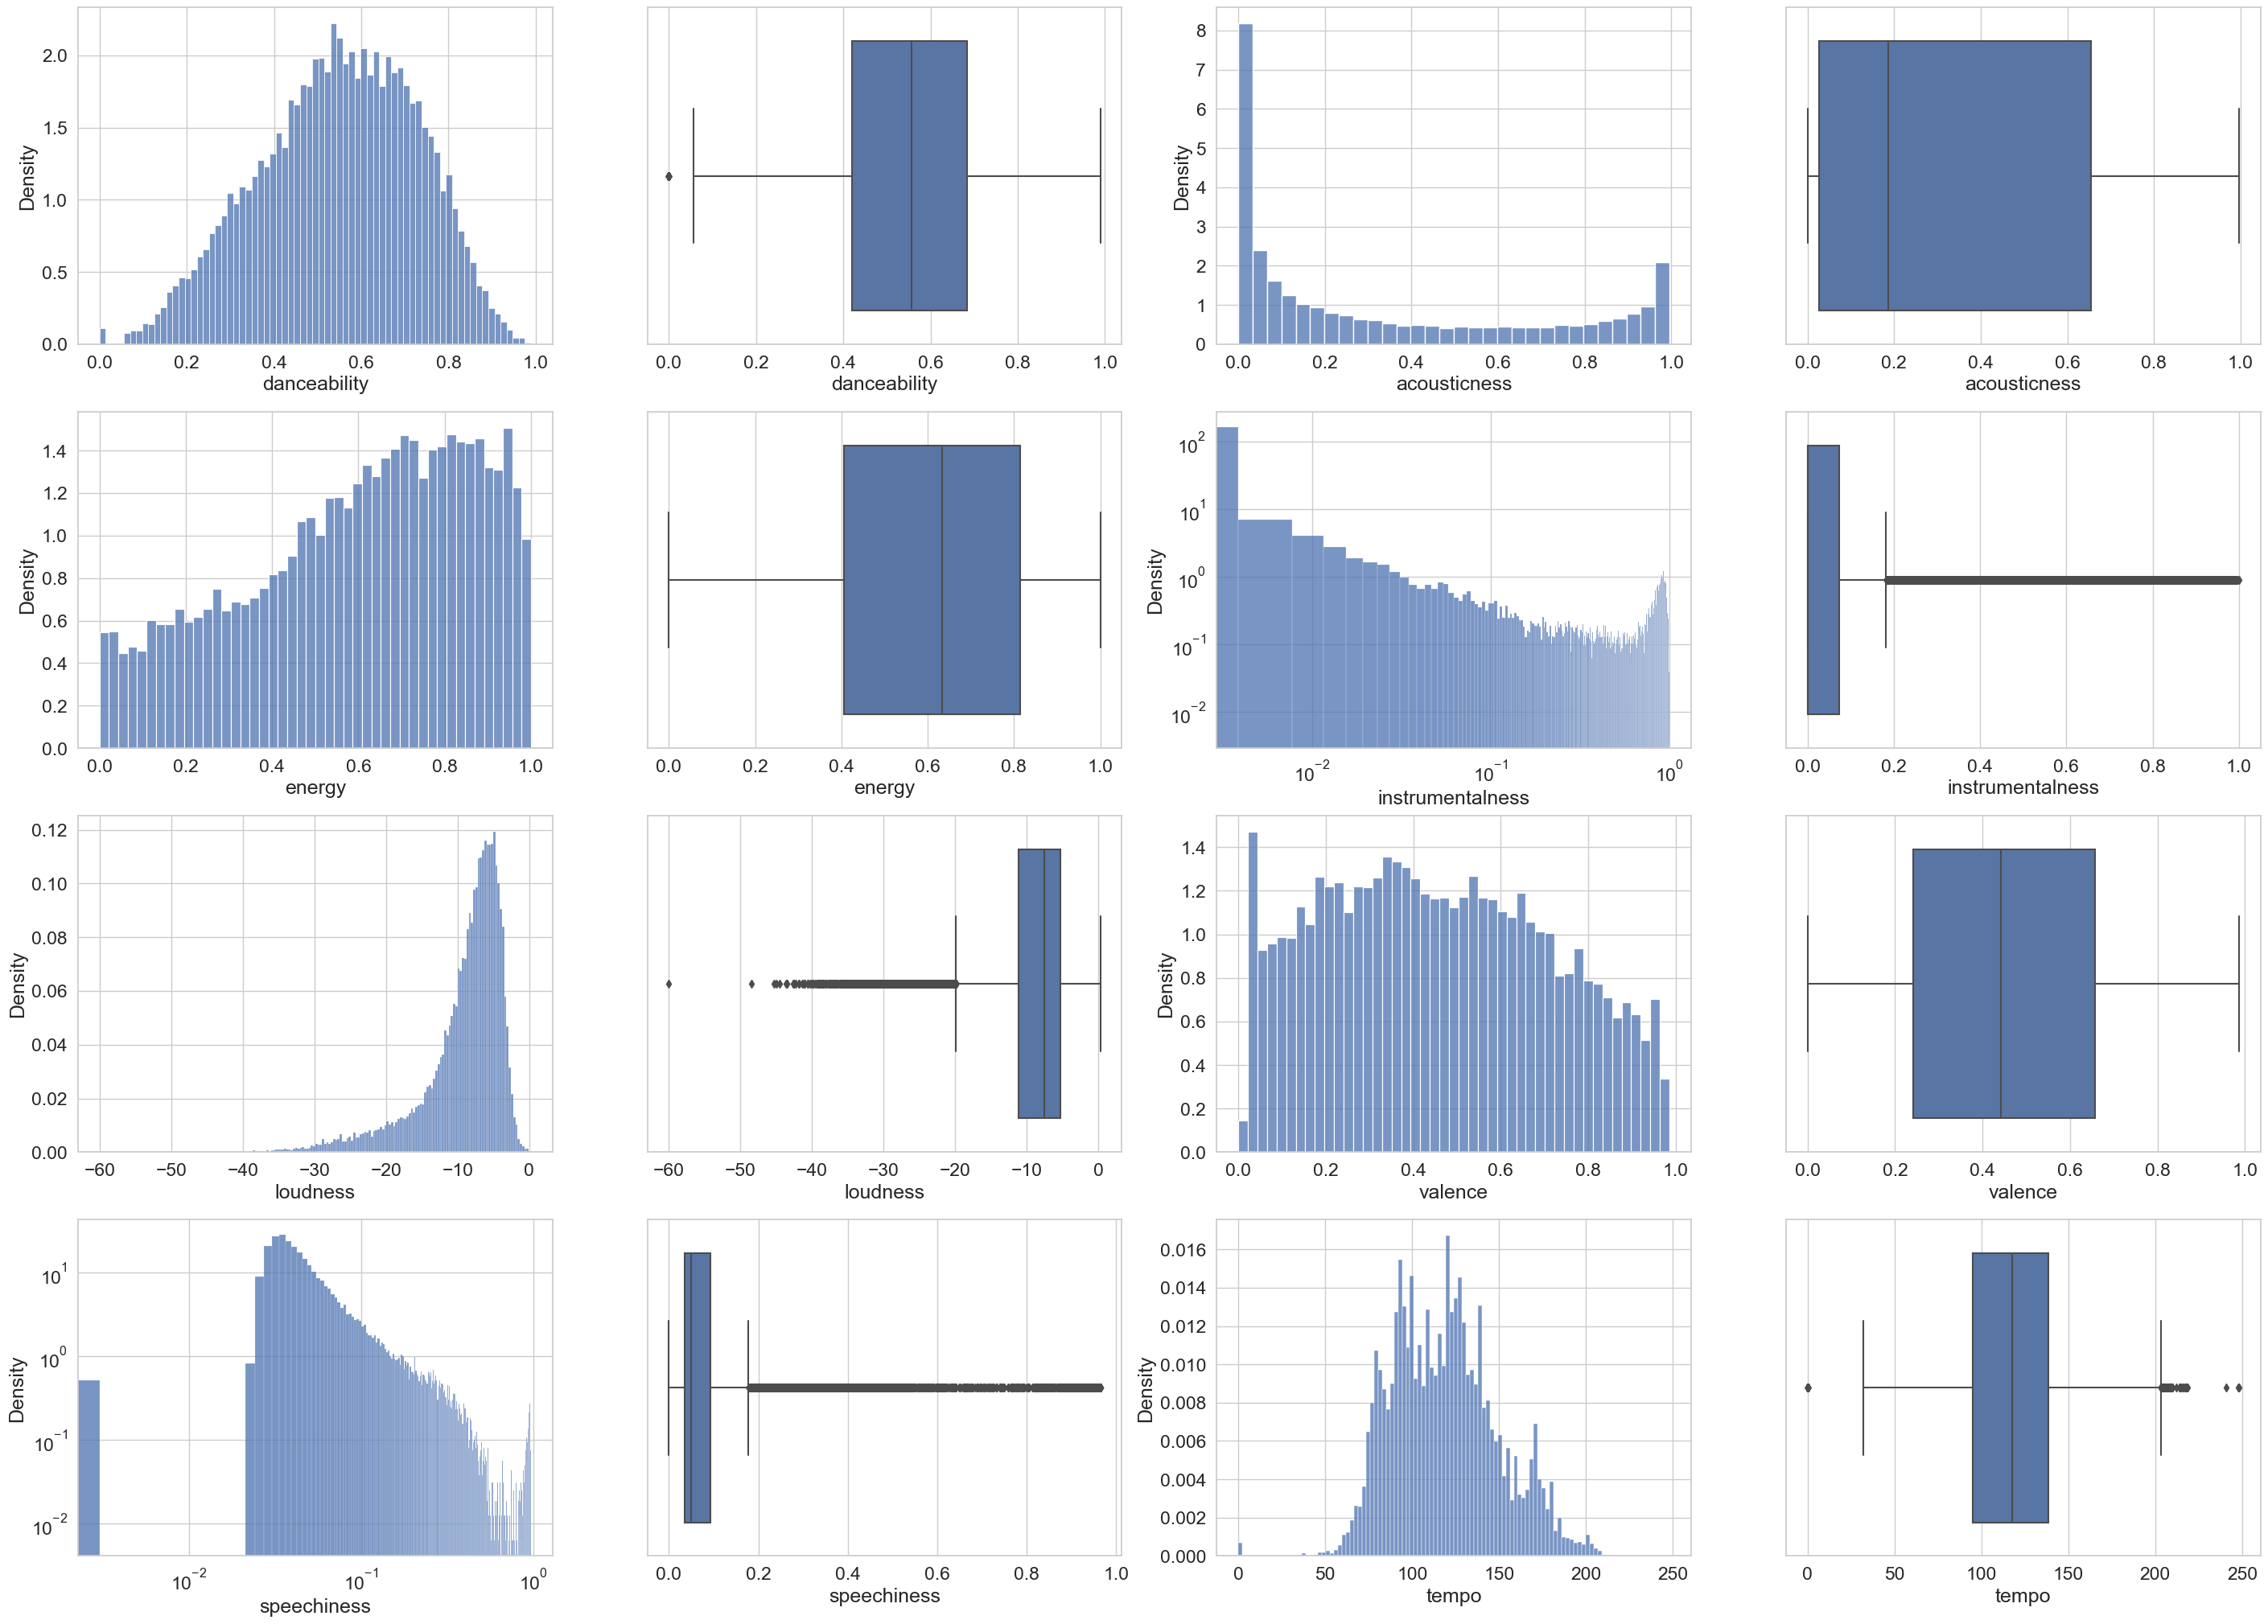

In [11]:
fig, axes = plt.subplots(4, 4, figsize = (35, 25))
sns.histplot(ax = axes[0, 0], data = audio_features, x = 'danceability', stat = 'density')
sns.boxplot(ax = axes[0, 1], data = audio_features, x = 'danceability')

sns.histplot(ax = axes[1, 0], data = audio_features, x = 'energy', stat = 'density')
sns.boxplot(ax = axes[1, 1], data = audio_features, x = 'energy')

sns.histplot(ax = axes[2, 0], data = audio_features, x = 'loudness', stat = 'density')
sns.boxplot(ax = axes[2, 1], data = audio_features, x = 'loudness')

sns.histplot(ax = axes[3, 0], data = audio_features, x = 'speechiness', stat = 'density')
sns.boxplot(ax = axes[3, 1], data = audio_features, x = 'speechiness')

sns.histplot(ax = axes[0, 2], data = audio_features, x = 'acousticness', stat = 'density')
sns.boxplot(ax = axes[0, 3], data = audio_features, x = 'acousticness')

sns.histplot(ax = axes[1, 2], data = audio_features, x = 'instrumentalness', stat = 'density')
sns.boxplot(ax = axes[1, 3], data = audio_features, x = 'instrumentalness')

sns.histplot(ax = axes[2, 2], data = audio_features, x = 'valence', stat = 'density')
sns.boxplot(ax = axes[2, 3], data = audio_features, x = 'valence')

sns.histplot(ax = axes[3, 2], data = audio_features, x = 'tempo', stat = 'density')
sns.boxplot(ax = axes[3, 3], data = audio_features, x = 'tempo')
axes[3, 0].set(xscale = 'log', yscale = 'log')
axes[1, 2].set(xscale = 'log', yscale = 'log')

<AxesSubplot: xlabel='time_signature', ylabel='id'>

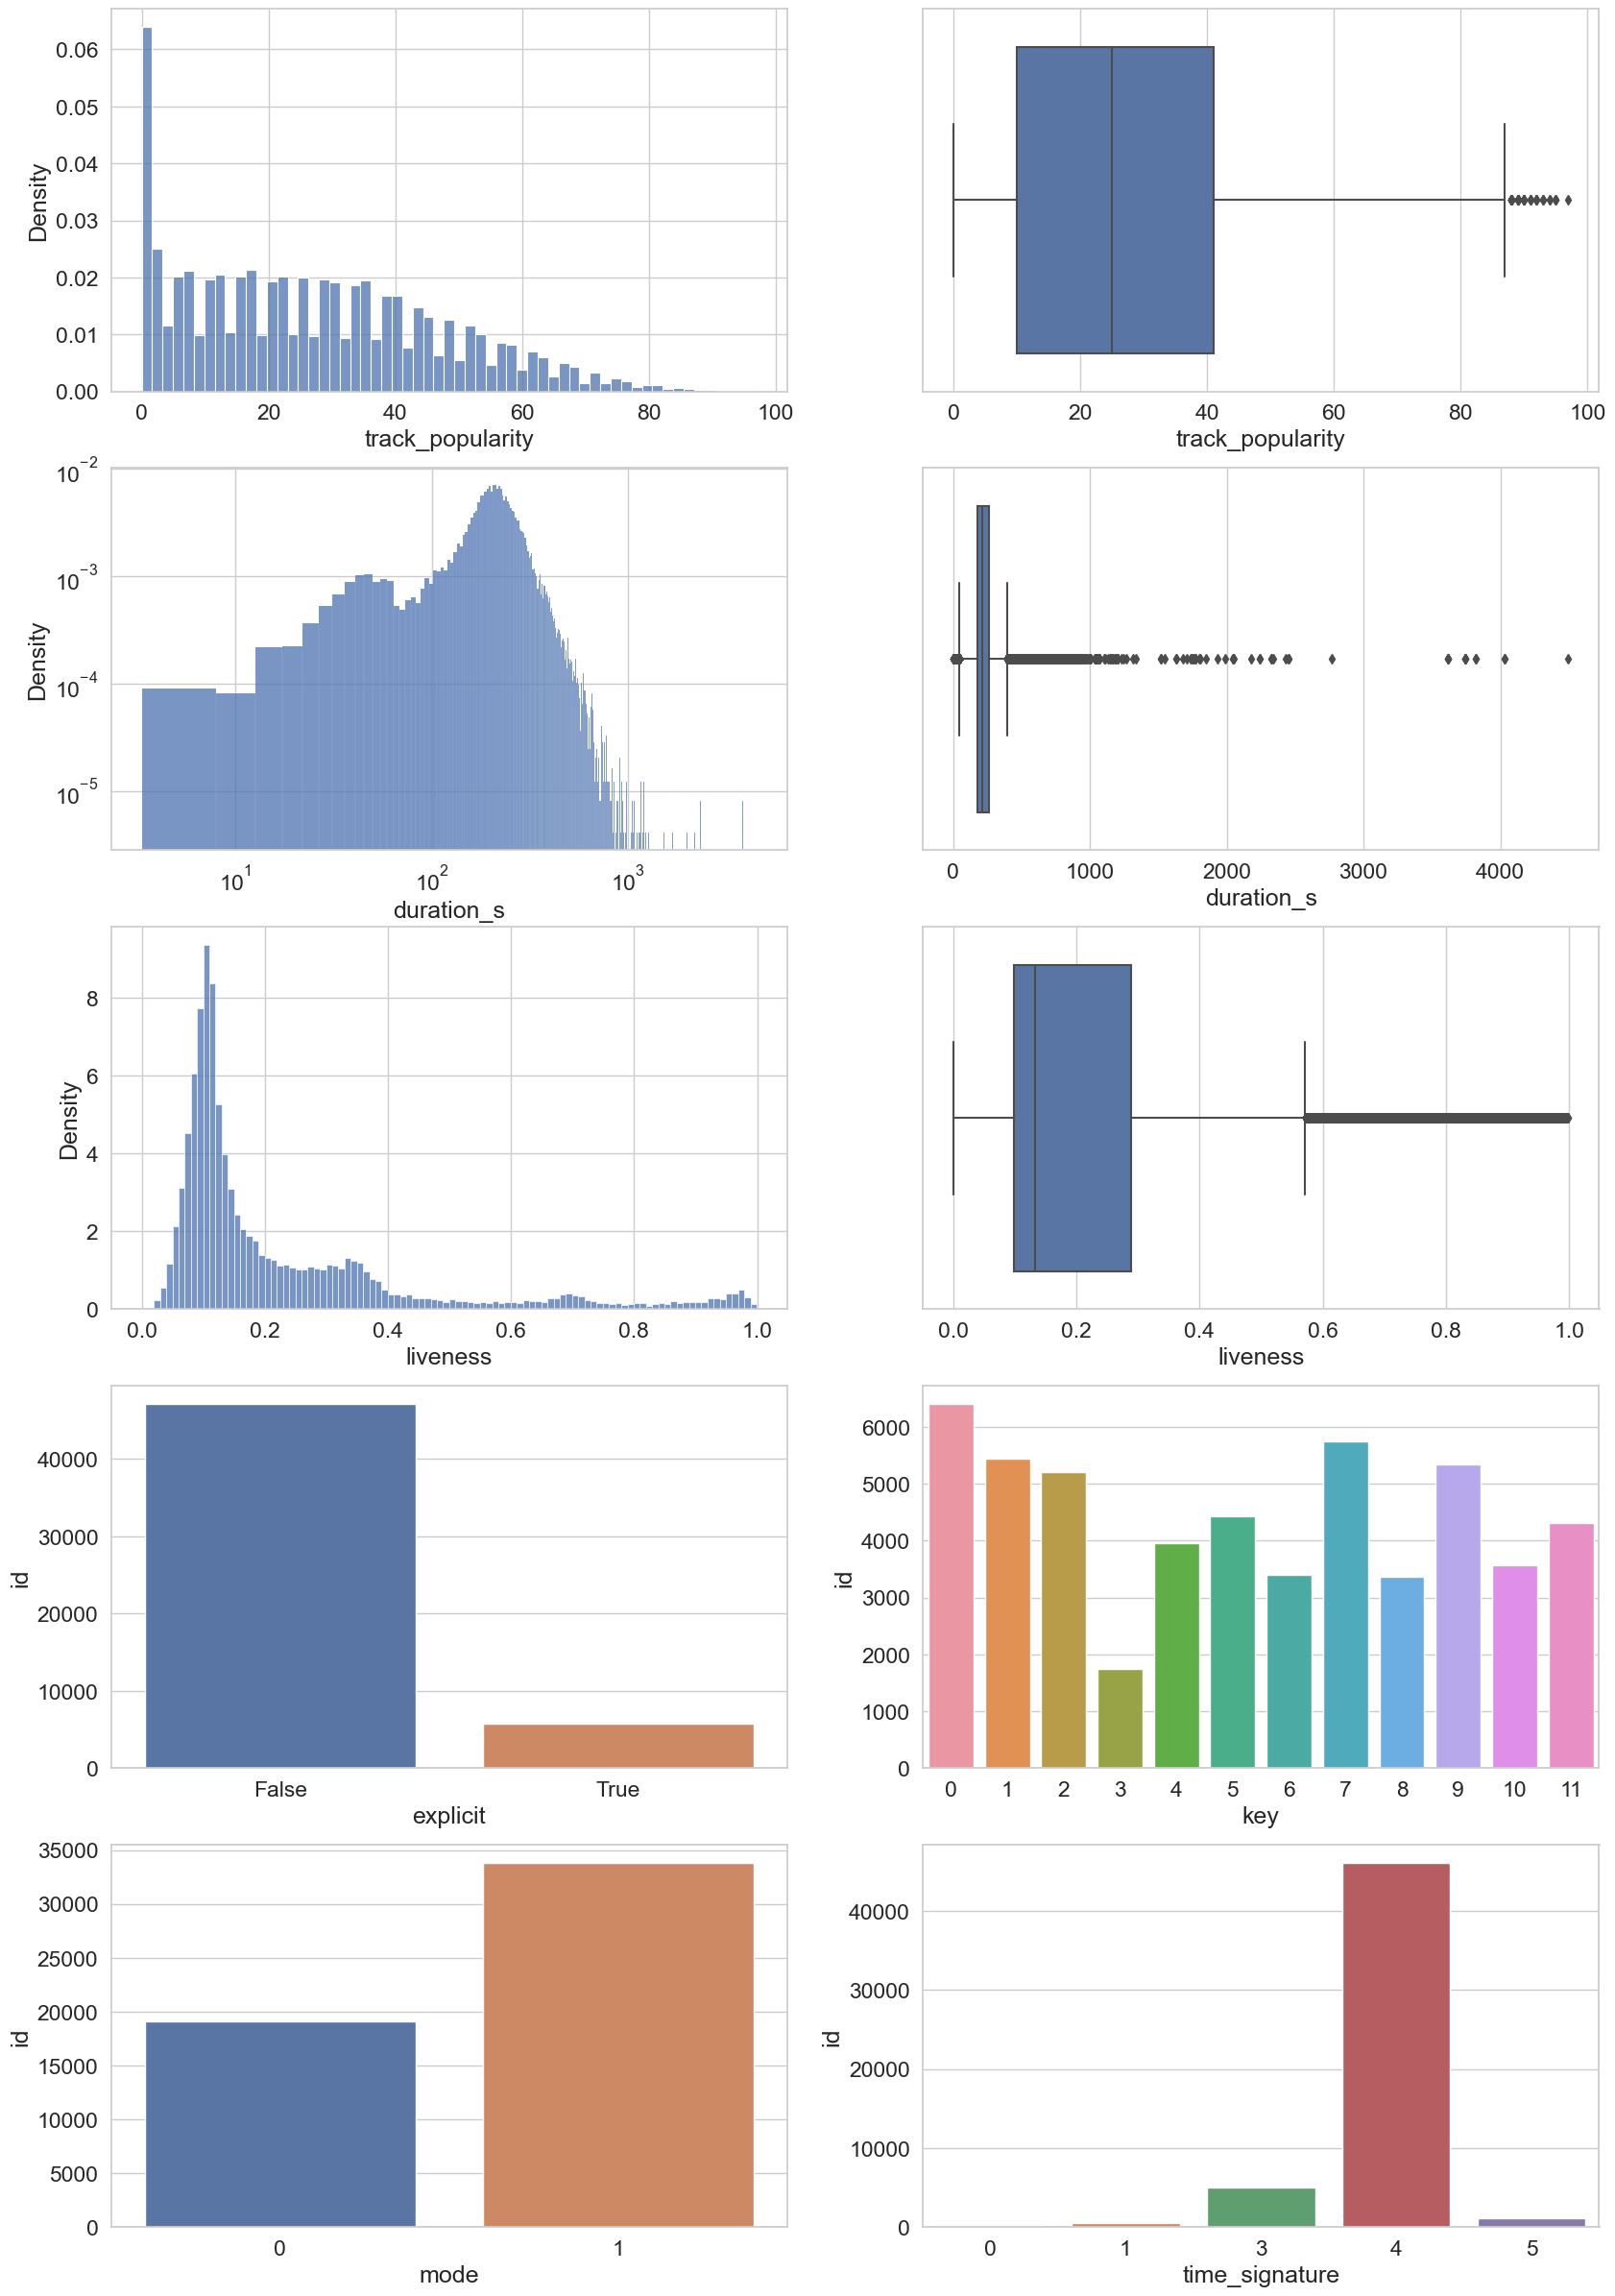

In [12]:
fig, axes = plt.subplots(5, 2, figsize = (20, 30))
sns.histplot(ax = axes[0, 0], data = audio_features, x = 'track_popularity', stat = 'density')
sns.boxplot(ax = axes[0, 1], data = audio_features, x = 'track_popularity')

sns.histplot(ax = axes[1, 0], data = audio_features, x = 'duration_s', stat = 'density')
sns.boxplot(ax = axes[1, 1], data = audio_features, x = 'duration_s')
axes[1, 0].set(xscale = 'log', yscale = 'log')

sns.histplot(ax = axes[2, 0], data = audio_features, x = 'liveness', stat = 'density')
sns.boxplot(ax = axes[2, 1], data = audio_features, x = 'liveness')

sns.barplot(ax = axes[3, 0], data = exp_cnt, x = exp_cnt.index, y = 'id')
sns.barplot(ax = axes[3, 1], data = key_cnt, x = key_cnt.index, y = 'id')
sns.barplot(ax = axes[4, 0], data = mode_cnt, x = mode_cnt.index, y = 'id')
sns.barplot(ax = axes[4, 1], data = ts_cnt, x = ts_cnt.index, y = 'id')

In [13]:
# one-hot encoding mode and explicit
from sklearn.preprocessing import OneHotEncoder

af_corr_df = audio_features
enc = OneHotEncoder()
encoded_cols = enc.fit_transform(af_corr_df[['explicit', 'mode']]).toarray()
print(enc.categories_)
enc_df = pd.DataFrame(encoded_cols, columns = ['explicit_false', 'explicit_true', 'mode_minor', 'mode_major'])
enc_df.head()

[array(['False', 'True'], dtype=object), array([0, 1])]


,explicit_false,explicit_true,mode_minor,mode_major
0,1.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0


In [14]:
af_corr_df = af_corr_df.merge(enc_df, left_index = True, right_index = True)
af_corr_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,time_signature,genre,explicit,artist_name,track_popularity,duration_s,explicit_false,explicit_true,mode_minor,mode_major
0,0.492,0.791,11,-5.045,1,0.0703,0.00816,0.000019,0.110,0.585,144.363,audio_features,0LJIVYOer8mlCmTrKoP9Kh,spotify:track:0LJIVYOer8mlCmTrKoP9Kh,https://api.spotify.com/v1/tracks/0LJIVYOer8ml...,https://api.spotify.com/v1/audio-analysis/0LJI...,4,jazz,False,Michael Bublé,54,218.391,1.0,0.0,0.0,1.0
1,0.278,0.354,5,-6.647,0,0.0372,0.50200,0.001240,0.309,0.090,121.803,audio_features,3xZFuVIvzqBImEYJydRkp9,spotify:track:3xZFuVIvzqBImEYJydRkp9,https://api.spotify.com/v1/tracks/3xZFuVIvzqBI...,https://api.spotify.com/v1/audio-analysis/3xZF...,3,jazz,False,Michael Bublé,47,208.866,1.0,0.0,1.0,0.0
2,0.509,0.457,6,-6.021,1,0.0381,0.39800,0.000000,0.104,0.521,116.472,audio_features,1ugWQPtI7SNYDXqEwuEjVm,spotify:track:1ugWQPtI7SNYDXqEwuEjVm,https://api.spotify.com/v1/tracks/1ugWQPtI7SNY...,https://api.spotify.com/v1/audio-analysis/1ugW...,4,jazz,False,Michael Bublé,52,185.531,1.0,0.0,0.0,1.0
3,0.401,0.712,8,-4.518,1,0.0300,0.03710,0.001890,0.091,0.561,84.343,audio_features,4BECSdUBaiMX0dNmLHr0kZ,spotify:track:4BECSdUBaiMX0dNmLHr0kZ,https://api.spotify.com/v1/tracks/4BECSdUBaiMX...,https://api.spotify.com/v1/audio-analysis/4BEC...,4,jazz,False,Michael Bublé,53,197.755,1.0,0.0,0.0,1.0
4,0.506,0.612,11,-6.297,1,0.0607,0.03010,0.000000,0.116,0.527,139.931,audio_features,7zqznhNk8DZbwo8fWIF82V,spotify:track:7zqznhNk8DZbwo8fWIF82V,https://api.spotify.com/v1/tracks/7zqznhNk8DZb...,https://api.spotify.com/v1/audio-analysis/7zqz...,3,jazz,False,Michael Bublé,51,143.386,1.0,0.0,0.0,1.0


/var/folders/6g/t90358yn4ynclrp0db92rf1c0000gn/T/ipykernel_23791/2231766332.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(af_corr_df.corr(), vmin = -1, vmax = 1, annot = True, cmap = 'BrBG')


<AxesSubplot: >

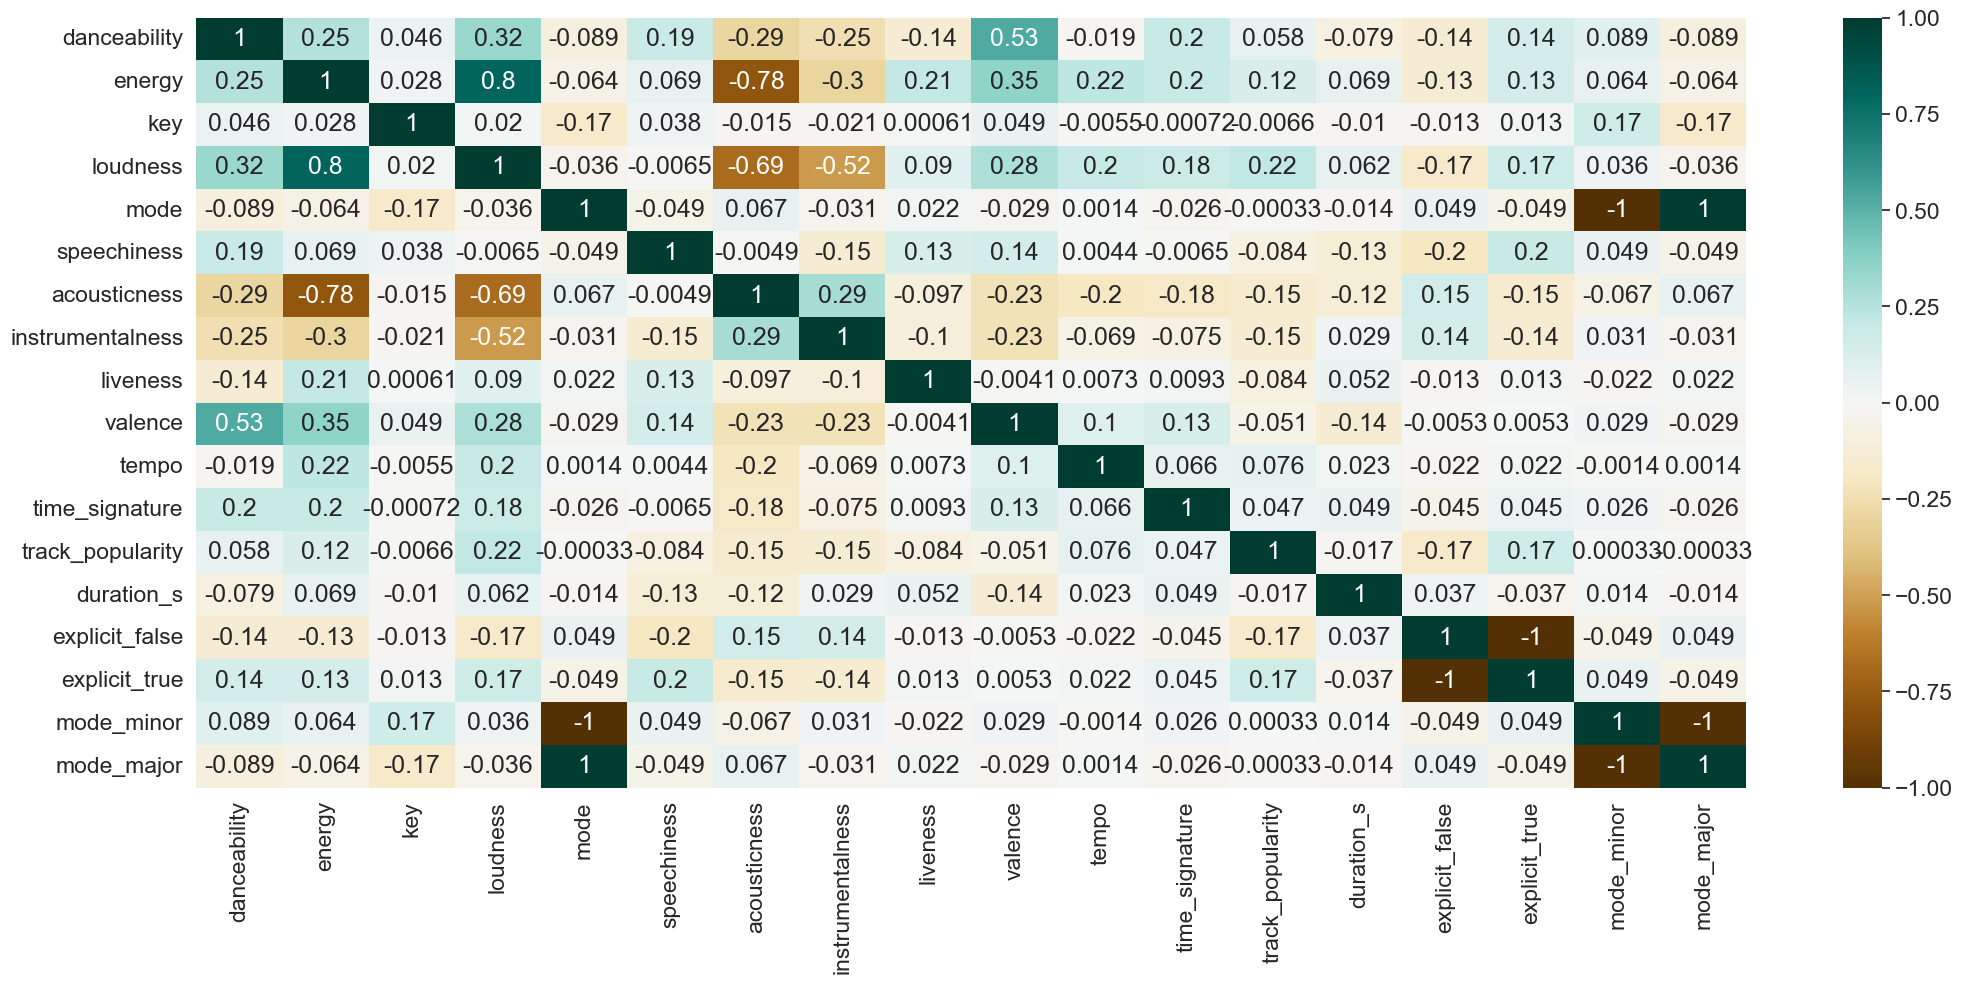

In [15]:
plt.figure(figsize = (25, 10))
sns.heatmap(af_corr_df.corr(), vmin = -1, vmax = 1, annot = True, cmap = 'BrBG')

## Feature Engineering

In terms checking for multicollinearity, we're going to use 0.7/0.8 as our cutoff. 

- Energy and loudness have a high correlation of 0.8
- Energy and acousticness have a high correlation of -0.78

Thus, we will be dropping both loudness and acousticness since they're also both not useful to determining mood classes. Although key and mode aren't actually correlated with each other, we will still drop the key feature. 

We'll also be dropping liveness and duration because they have too many outliers. 

Since explicit has a lot of 'False', it seems that it won't add much to figuring out mood classes. 

Although instrumentalness and speechiness don't have much correlation with each other, we'll be dropping both of them as they have too many outliers. 

Columns we'll be keeping: danceability, energy, mode, valence, tempo, time_signature. 

## Potential Transformations

- We will have to one-hot encode the mode feature. 
- We'll have to standardize the other numerical features

In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [17]:
audio_features_ml = audio_features[['danceability', 'energy', 'mode', 'valence', 'tempo', 'time_signature']]

In [18]:
# encoding and scaling features
enc = OneHotEncoder()
encoded_cols = enc.fit_transform(audio_features_ml[['mode']]).toarray()
print(enc.categories_)
enc_df = pd.DataFrame(encoded_cols, columns = ['mode_minor', 'mode_major'])
enc_df.head()

[array([0, 1])]


,mode_minor,mode_major
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [19]:
audio_features_ml = audio_features_ml.merge(enc_df, left_index = True, right_index = True) \
    .drop(['mode'], axis = 1)
audio_features_ml.head()

,danceability,energy,valence,tempo,time_signature,mode_minor,mode_major
0,0.492,0.791,0.585,144.363,4,0.0,1.0
1,0.278,0.354,0.090,121.803,3,1.0,0.0
2,0.509,0.457,0.521,116.472,4,0.0,1.0
3,0.401,0.712,0.561,84.343,4,0.0,1.0
4,0.506,0.612,0.527,139.931,3,0.0,1.0


In [20]:
numeric_columns = ['danceability', 'energy', 'valence', 'tempo']
cat_columns = ['time_signature', 'mode_minor', 'mode_major']

In [21]:
scaler = StandardScaler()
scaled_cols = pd.DataFrame(scaler.fit_transform(audio_features_ml[numeric_columns]))
audio_features_ml[numeric_columns] = scaled_cols
audio_features_ml.head()

,danceability,energy,valence,tempo,time_signature,mode_minor,mode_major
0,-0.297043,0.745460,0.501400,0.835963,4,0.0,1.0
1,-1.477316,-0.902766,-1.423987,0.097770,3,1.0,0.0
2,-0.203283,-0.514282,0.252461,-0.076667,4,0.0,1.0
3,-0.798935,0.447497,0.408048,-1.127971,4,0.0,1.0
4,-0.219829,0.070329,0.275799,0.690942,3,0.0,1.0


## Types of Clustering
https://developers.google.com/machine-learning/clustering/clustering-algorithms 

## Gaussian Mixture Models (GMM)
https://aabkn.github.io/GMM_visually_explained 

### Motivation
K-means clustering isn't flexible enough to account for non-spherical clusters and tries to force-fit data into them. This results in a mixing of cluster assignments where the resulting clusters overlap. 

It's also a hard clustering method–the distance between the centroid and the most distant point of the cluster acts as a hard cutoff for cluster assignment. 

It can't measure probability or uncertainty of a cluster assignment. 

### What is GMM?
It is a clustering technique that attempts to find a mixture of Gaussian probability distributions that best model any input dataset. It assumes that data is composed of different Gaussian distributions. 

It employs the expectation-maximization (EM) algorithm to cluster points and assign probabilities of belonging to a cluster to each point:
1. Choose start guesses for location and shape
2. Repeat until converged:
    1. E-step: For each observation, find weights encoding probability of membership in each cluster
    2. M-step: For each cluster, update its parameters (mean, variance, mixture parameter) making use of the weights (probability of membership). This is updated in order to take steps to maximize the likelihood of the points belonging to the cluster. 

#### What is the Expectation-Maximization (EM) Algorithm?

If we know which component a point came from (class label), we can learn the parameters of each component independently. On the other hand, if we know the parameters of all components, we can assign points to their most probable class. 

This leads us to the idea that we can iteratively update the parameters and class labels based on previous estimates of them. 

The EM algorithm does exactly that except it uses probabilities of a point belonging to a cluster. 

There are 2 main components that make up the EM algorithm. The expectation component calculates the posterior probability that a point belongs to cluster k given the cluster is a Gaussian distribution with a set of parameters.

The maximization component first involves taking the expected value of the log-likelihood given the posterior distribution of the cluster assignments. This is because in GMM, uncertainty is accounted for when doing cluster assignments and thus there is randomness in cluster assignments. To estimate the log-likelihood, we take the expectation of it and then maximize on it to find the best parameters that fit the Gaussian mixture distribution and can thus best model the data. 

### Assumptions
- The data is assumed to be of a Gaussian mixture distrbution
- The observations in the data are independent

In [22]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

## Silhouette Score Plot

In [ ]:
s_score = []
n_clusters = list(range(2, 21))
for n in n_clusters: 
    gmm_model = GaussianMixture(n, random_state = 2002, init_params = 'k-means++', n_init = 10)
    labels = gmm_model.fit_predict(audio_features_ml)
    s_score.append(silhouette_score(audio_features_ml, labels, metric = 'euclidean'))

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(range(2, 21), s_score, 'bo-', alpha = 1, color = 'black')
plt.title('Silhouette plot')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')

## BIC Score Plot 

In [ ]:
bic_score = []
n_clusters = list(range(2, 5))
for n in n_clusters: 
    gmm_model = GaussianMixture(n, random_state = 2002, init_params = 'k-means++', n_init = 10)
    model = gmm_model.fit(audio_features_ml)
    bic_score.append(model.bic(audio_features_ml))

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(range(2, 5), bic_score, 'bo-', alpha = 1, color = 'black')
plt.title('BIC score plot')
plt.xlabel('Number of components (k)')
plt.ylabel('Score')

In [ ]:
import sklearn.model_selection as ms
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## Results (n = 2)

In [23]:
gmm_model_2 = GaussianMixture(2, random_state = 2002, init_params = 'k-means++', n_init = 10)
labels = gmm_model_2.fit_predict(audio_features_ml)

In [24]:
audio_features_ml['cluster'] = labels + 1
audio_features_ml['mode'] = audio_features['mode']
audio_features_ml.head()

,danceability,energy,valence,tempo,time_signature,mode_minor,mode_major,cluster,mode
0,-0.297043,0.745460,0.501400,0.835963,4,0.0,1.0,2,1
1,-1.477316,-0.902766,-1.423987,0.097770,3,1.0,0.0,1,0
2,-0.203283,-0.514282,0.252461,-0.076667,4,0.0,1.0,2,1
3,-0.798935,0.447497,0.408048,-1.127971,4,0.0,1.0,2,1
4,-0.219829,0.070329,0.275799,0.690942,3,0.0,1.0,1,1


In [25]:
numeric_columns = list(audio_features_ml.columns[:4])
cluster_1 = audio_features_ml[audio_features_ml['cluster'] == 1]
cluster_2 = audio_features_ml[audio_features_ml['cluster'] == 2]

/Users/huongngo/opt/anaconda3/envs/song_rec/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/huongngo/opt/anaconda3/envs/song_rec/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


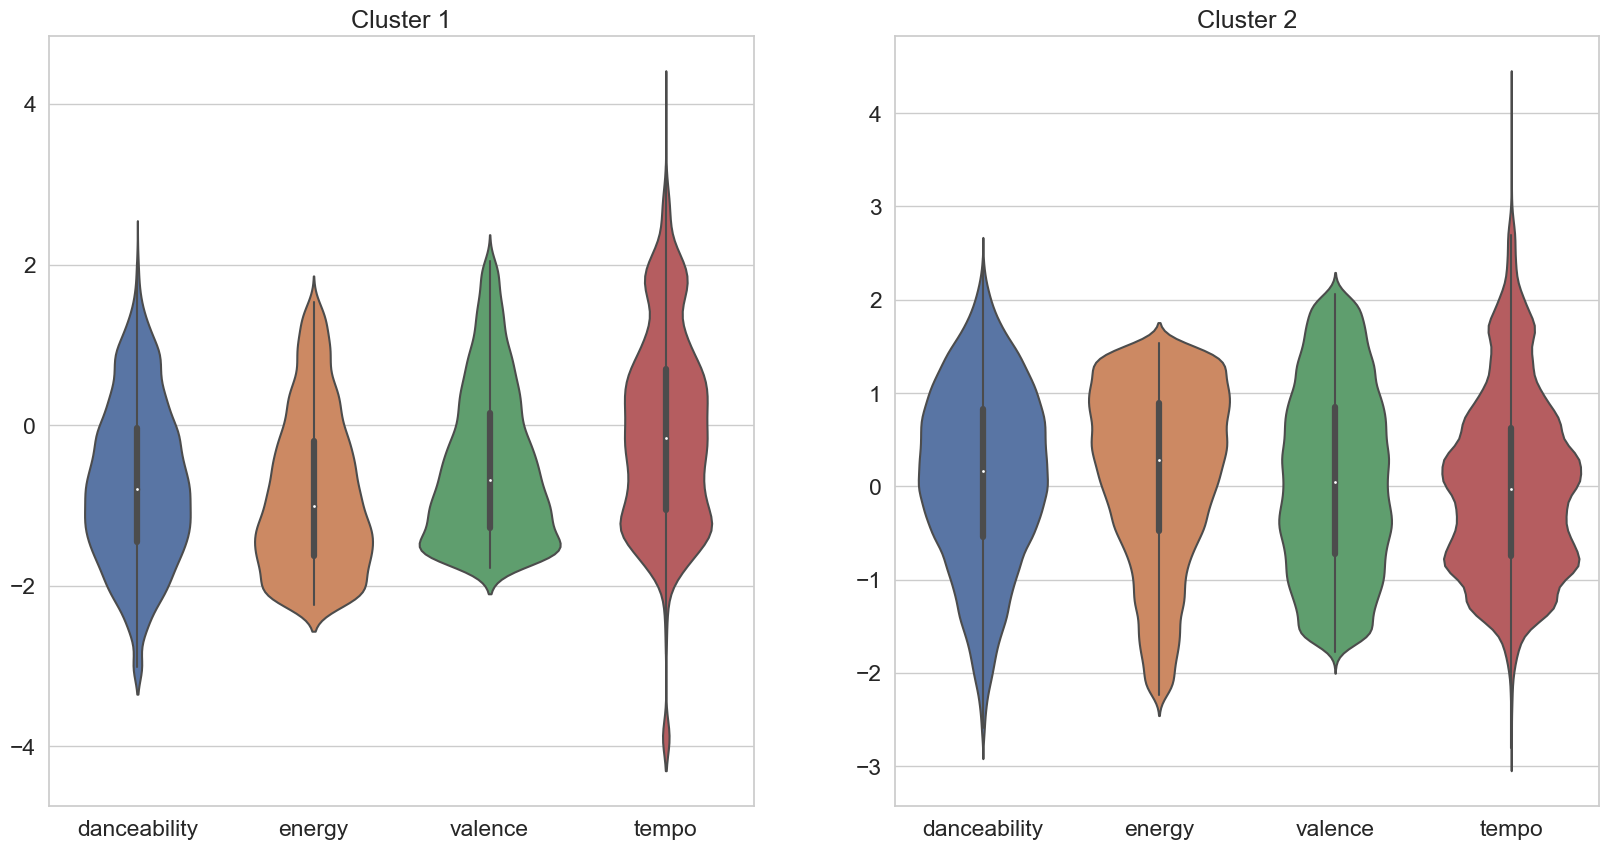

In [26]:
fig, axes = plt.subplots(1, 2, figsize = (20, 10))
sns.violinplot(ax = axes[0], data = cluster_1[numeric_columns])
axes[0].title.set_text('Cluster 1')
sns.violinplot(ax = axes[1], data = cluster_2[numeric_columns])
axes[1].title.set_text('Cluster 2')

In [27]:
cluster_1_mode_cnt = pd.DataFrame(cluster_1.groupby(['mode']).count()['cluster'])
cluster_2_mode_cnt = pd.DataFrame(cluster_2.groupby(['mode']).count()['cluster'])

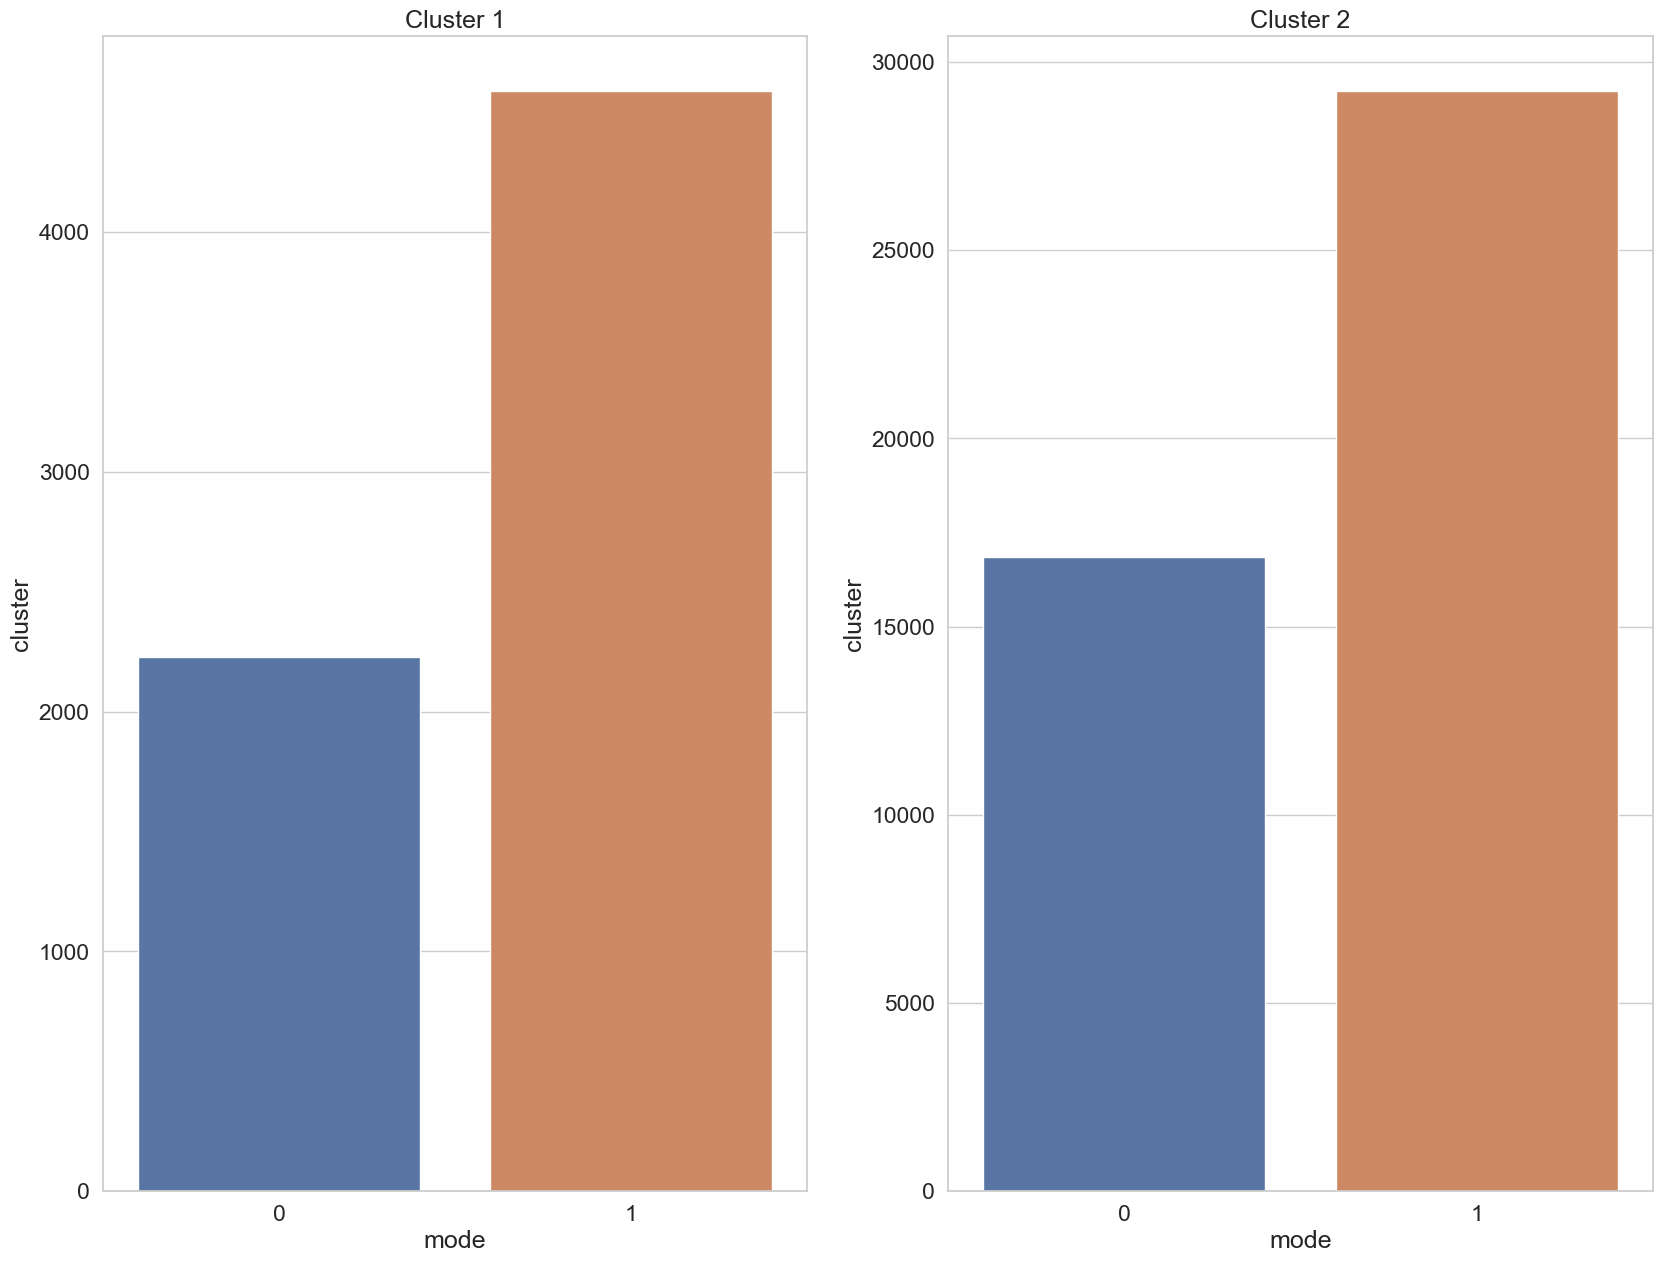

In [28]:
fig, axes = plt.subplots(1, 2, figsize = (20, 15))
sns.barplot(ax = axes[0], data = cluster_1_mode_cnt, x = cluster_1_mode_cnt.index, y = 'cluster')
axes[0].title.set_text('Cluster 1')
sns.barplot(ax = axes[1], data = cluster_2_mode_cnt, x = cluster_2_mode_cnt.index, y = 'cluster')
axes[1].title.set_text('Cluster 2')

## Cluster 1 -> Angry + Sad + Calm?

In [29]:
s_score_1 = []
n_clusters = list(range(2, 5))
for n in n_clusters: 
    gmm_model = GaussianMixture(n, random_state = 2002, init_params = 'k-means++', n_init = 10)
    labels = gmm_model.fit_predict(cluster_1)
    s_score_1.append(silhouette_score(cluster_1, labels, metric = 'euclidean'))

/var/folders/6g/t90358yn4ynclrp0db92rf1c0000gn/T/ipykernel_23791/2646541596.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(2, 5), s_score_1, 'bo-', alpha = 1, color = 'black')


Text(0, 0.5, 'Score')

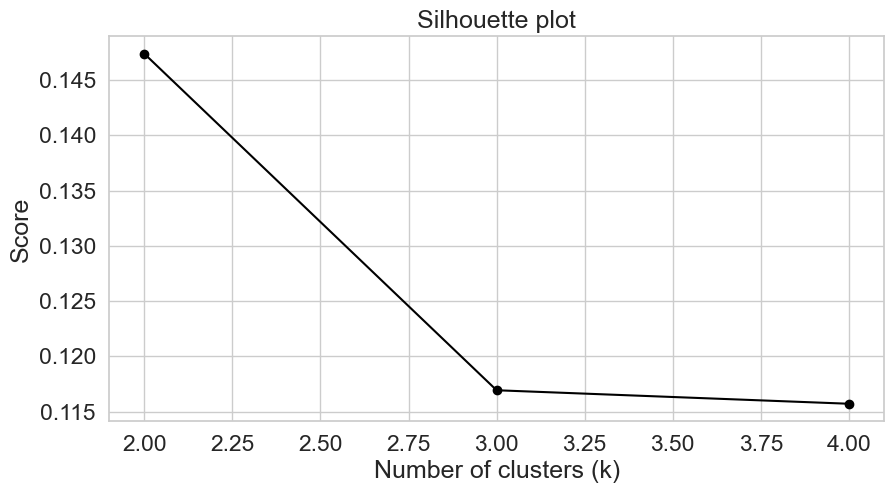

In [30]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(range(2, 5), s_score_1, 'bo-', alpha = 1, color = 'black')
plt.title('Silhouette plot')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')

In [31]:
cluster_1_df = cluster_1

In [32]:
gmm_model_3 = GaussianMixture(3, random_state = 2002, init_params = 'k-means++', n_init = 10)
labels_3 = gmm_model_3.fit_predict(cluster_1_df)

In [33]:
cluster_1_df.head()

,danceability,energy,valence,tempo,time_signature,mode_minor,mode_major,cluster,mode
1,-1.477316,-0.902766,-1.423987,0.097770,3,1.0,0.0,1,0
4,-0.219829,0.070329,0.275799,0.690942,3,0.0,1.0,1,1
6,-1.350464,-0.872592,-0.751074,1.956864,3,0.0,1.0,1,1
7,-0.804450,-0.333242,0.034640,-0.431955,3,0.0,1.0,1,1
10,-1.973692,-0.925396,-1.483888,-1.250414,1,0.0,1.0,1,1


In [34]:
cluster_1_df['cluster'] = labels_3 + 1
cluster_1_df.head()

/var/folders/6g/t90358yn4ynclrp0db92rf1c0000gn/T/ipykernel_23791/3426395803.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_1_df['cluster'] = labels_3 + 1


,danceability,energy,valence,tempo,time_signature,mode_minor,mode_major,cluster,mode
1,-1.477316,-0.902766,-1.423987,0.097770,3,1.0,0.0,1,0
4,-0.219829,0.070329,0.275799,0.690942,3,0.0,1.0,2,1
6,-1.350464,-0.872592,-0.751074,1.956864,3,0.0,1.0,2,1
7,-0.804450,-0.333242,0.034640,-0.431955,3,0.0,1.0,2,1
10,-1.973692,-0.925396,-1.483888,-1.250414,1,0.0,1.0,3,1


In [35]:
temp_1 = cluster_1_df[cluster_1_df['cluster'] == 1]
temp_2 = cluster_1_df[cluster_1_df['cluster'] == 2]
temp_3 = cluster_1_df[cluster_1_df['cluster'] == 3]

/Users/huongngo/opt/anaconda3/envs/song_rec/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/huongngo/opt/anaconda3/envs/song_rec/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/huongngo/opt/anaconda3/envs/song_rec/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


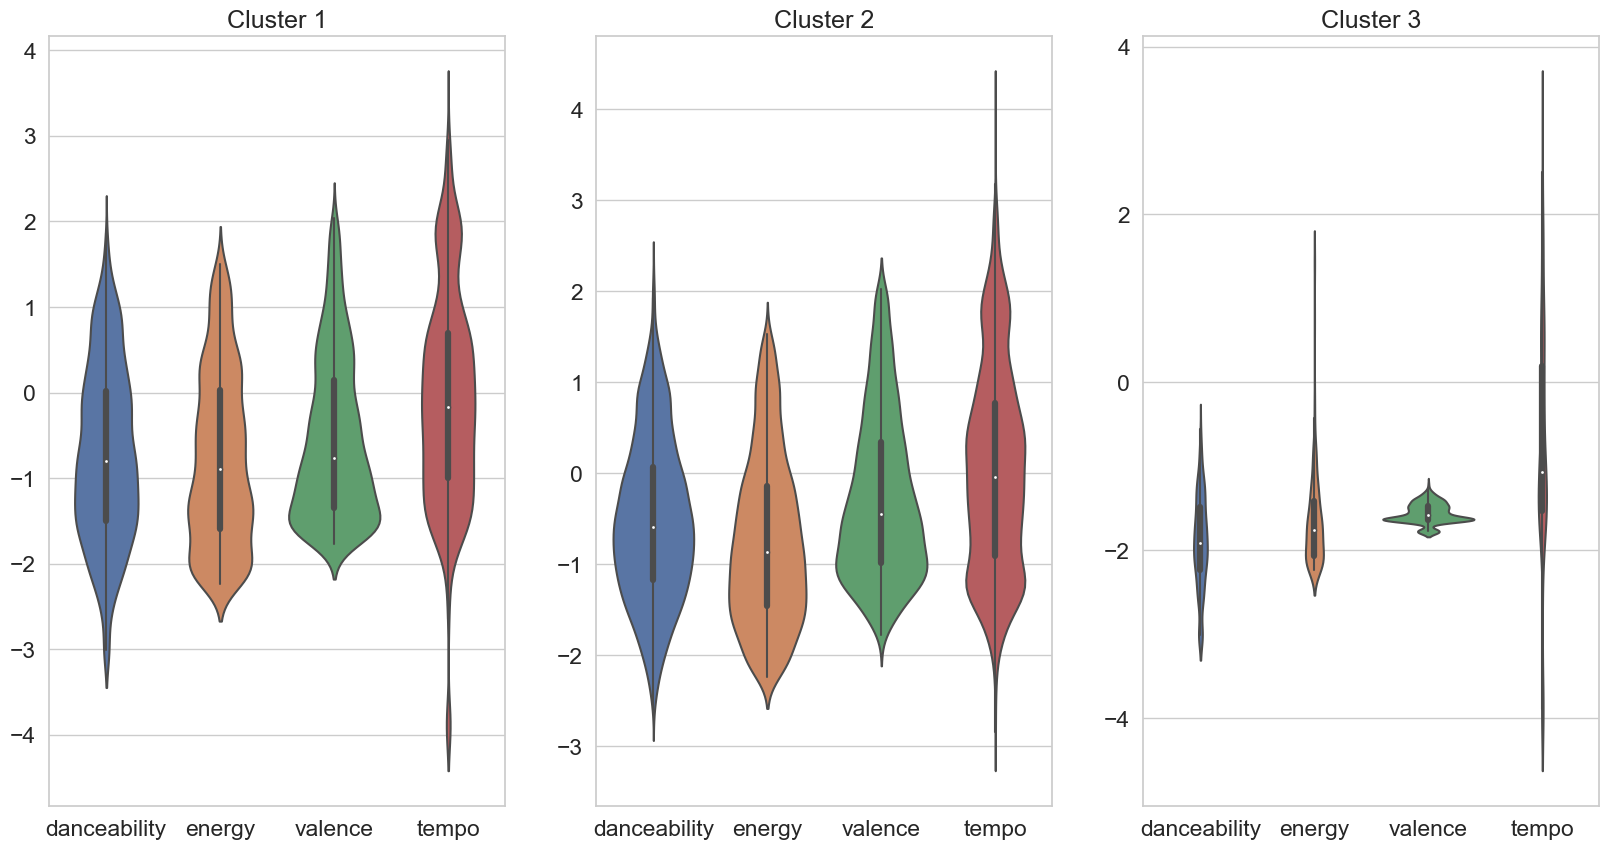

In [37]:
fig, axes = plt.subplots(1, 3, figsize = (20, 10))
sns.violinplot(ax = axes[0], data = temp_1[numeric_columns])
axes[0].title.set_text('Cluster 1')
sns.violinplot(ax = axes[1], data = temp_2[numeric_columns])
axes[1].title.set_text('Cluster 2')
sns.violinplot(ax = axes[2], data = temp_3[numeric_columns])
axes[2].title.set_text('Cluster 3')

In [38]:
cluster_1_mode_cnt = pd.DataFrame(temp_1.groupby(['mode']).count()['cluster'])
cluster_2_mode_cnt = pd.DataFrame(temp_2.groupby(['mode']).count()['cluster'])
cluster_3_mode_cnt = pd.DataFrame(temp_3.groupby(['mode']).count()['cluster'])

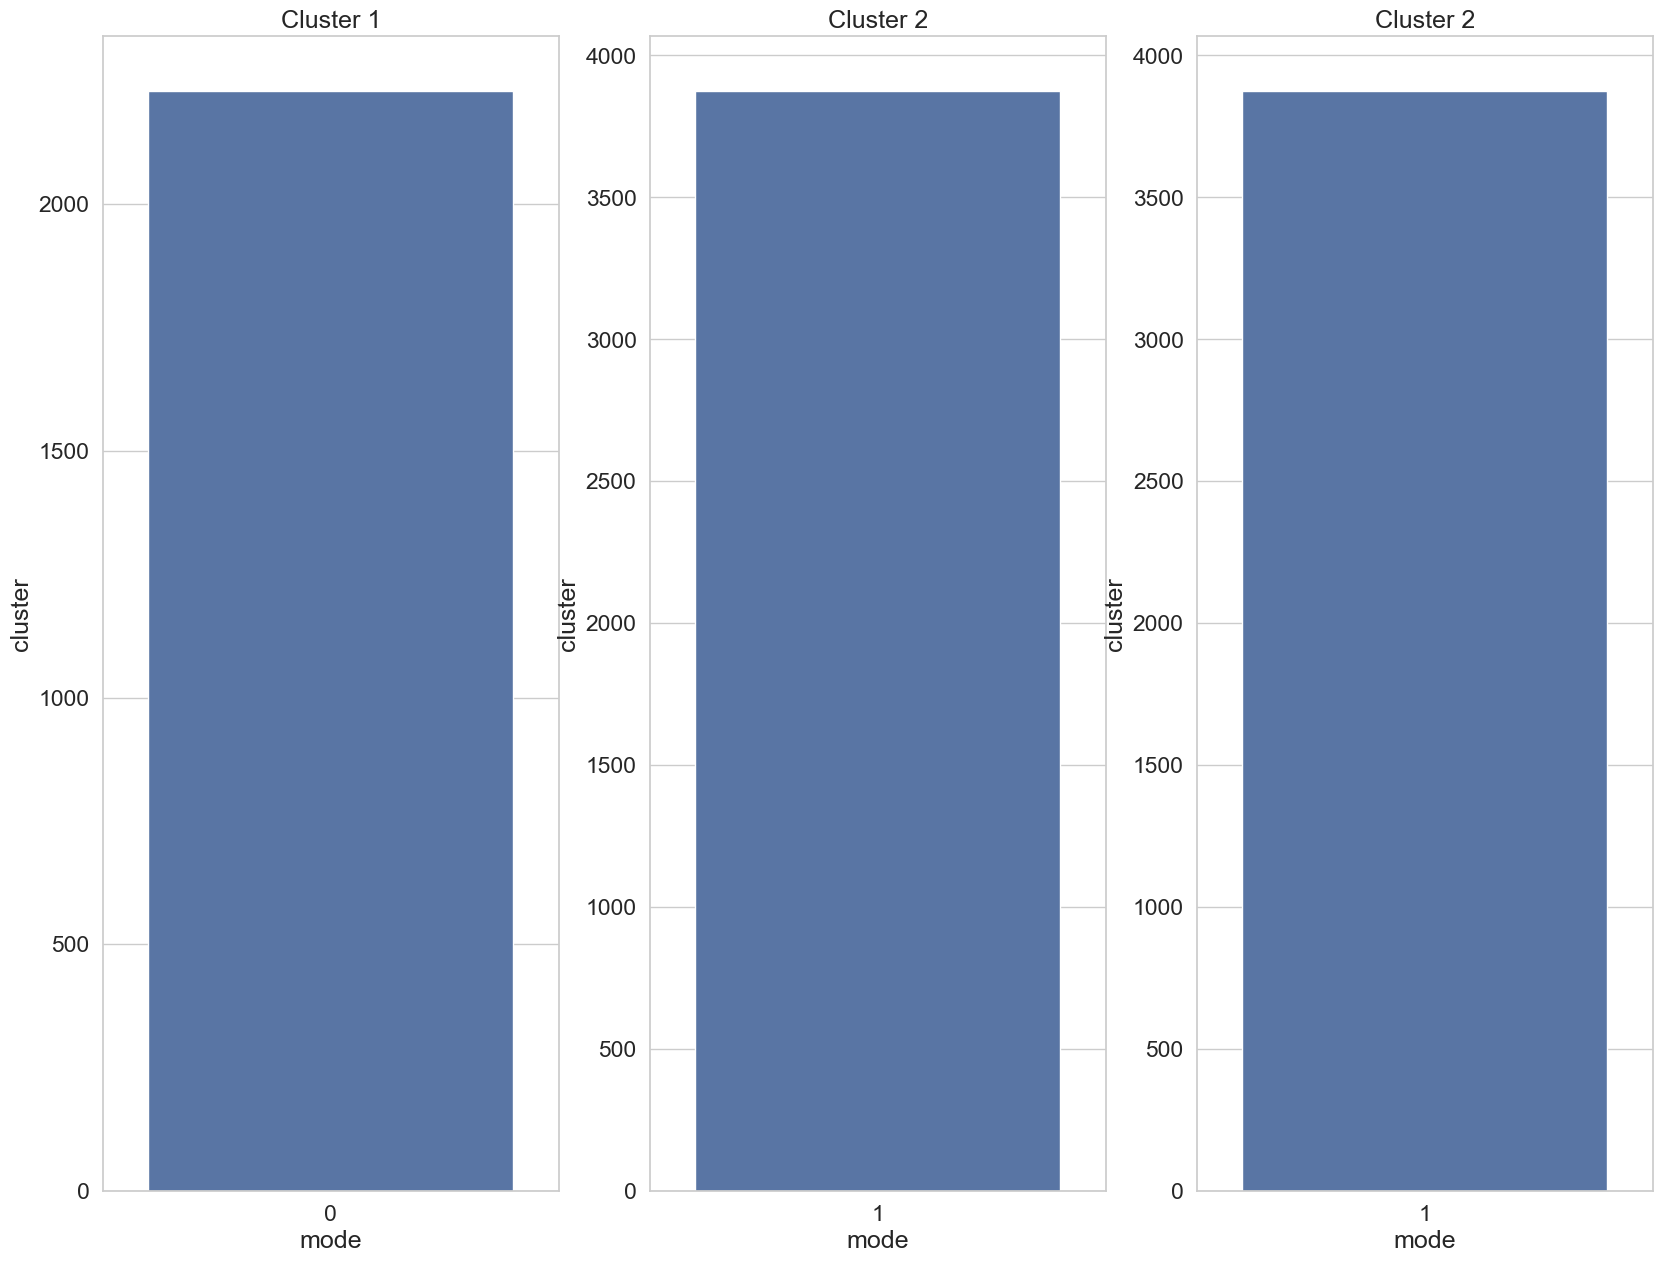

In [39]:
fig, axes = plt.subplots(1, 3, figsize = (20, 15))
sns.barplot(ax = axes[0], data = cluster_1_mode_cnt, x = cluster_1_mode_cnt.index, y = 'cluster')
axes[0].title.set_text('Cluster 1')
sns.barplot(ax = axes[1], data = cluster_2_mode_cnt, x = cluster_2_mode_cnt.index, y = 'cluster')
axes[1].title.set_text('Cluster 2')
sns.barplot(ax = axes[2], data = cluster_2_mode_cnt, x = cluster_2_mode_cnt.index, y = 'cluster')
axes[2].title.set_text('Cluster 3')

## Cluster 2 -> Happy + Angry?

In [40]:
s_score_2 = []
n_clusters = list(range(2, 5))
for n in n_clusters: 
    gmm_model = GaussianMixture(n, random_state = 2002, init_params = 'k-means++', n_init = 10)
    labels = gmm_model.fit_predict(cluster_2)
    s_score_2.append(silhouette_score(cluster_2, labels, metric = 'euclidean'))

/var/folders/6g/t90358yn4ynclrp0db92rf1c0000gn/T/ipykernel_23791/2779749681.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(2, 5), s_score_2, 'bo-', alpha = 1, color = 'black')


Text(0, 0.5, 'Score')

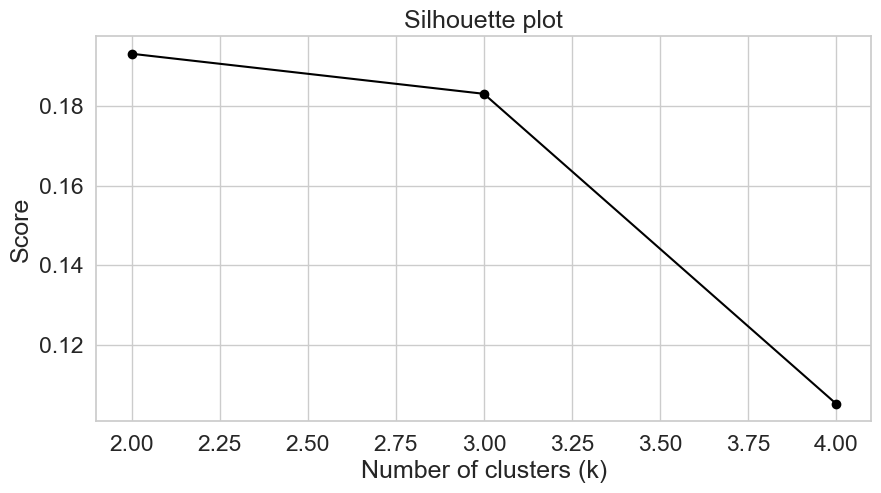

In [41]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(range(2, 5), s_score_2, 'bo-', alpha = 1, color = 'black')
plt.title('Silhouette plot')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')

In [42]:
cluster_2_df = cluster_2

In [45]:
gmm_model_4 = GaussianMixture(2, random_state = 2002, init_params = 'k-means++', n_init = 10)
labels_4 = gmm_model_4.fit_predict(cluster_2_df)

In [44]:
cluster_2_df.head()

,danceability,energy,valence,tempo,time_signature,mode_minor,mode_major,cluster,mode
0,-0.297043,0.745460,0.501400,0.835963,4,0.0,1.0,2,1
2,-0.203283,-0.514282,0.252461,-0.076667,4,0.0,1.0,2,1
3,-0.798935,0.447497,0.408048,-1.127971,4,0.0,1.0,2,1
5,0.761893,0.858611,1.660523,0.236050,4,1.0,0.0,2,0
8,-0.837542,0.051470,0.750339,-0.641437,4,1.0,0.0,2,0


In [46]:
cluster_2_df['cluster'] = labels_4 + 1
cluster_2_df.head()

/var/folders/6g/t90358yn4ynclrp0db92rf1c0000gn/T/ipykernel_23791/837198232.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_2_df['cluster'] = labels_4 + 1


,danceability,energy,valence,tempo,time_signature,mode_minor,mode_major,cluster,mode
0,-0.297043,0.745460,0.501400,0.835963,4,0.0,1.0,2,1
2,-0.203283,-0.514282,0.252461,-0.076667,4,0.0,1.0,2,1
3,-0.798935,0.447497,0.408048,-1.127971,4,0.0,1.0,2,1
5,0.761893,0.858611,1.660523,0.236050,4,1.0,0.0,1,0
8,-0.837542,0.051470,0.750339,-0.641437,4,1.0,0.0,1,0


In [47]:
temp_4 = cluster_2_df[cluster_2_df['cluster'] == 1]
temp_5 = cluster_2_df[cluster_2_df['cluster'] == 2]

/Users/huongngo/opt/anaconda3/envs/song_rec/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/huongngo/opt/anaconda3/envs/song_rec/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


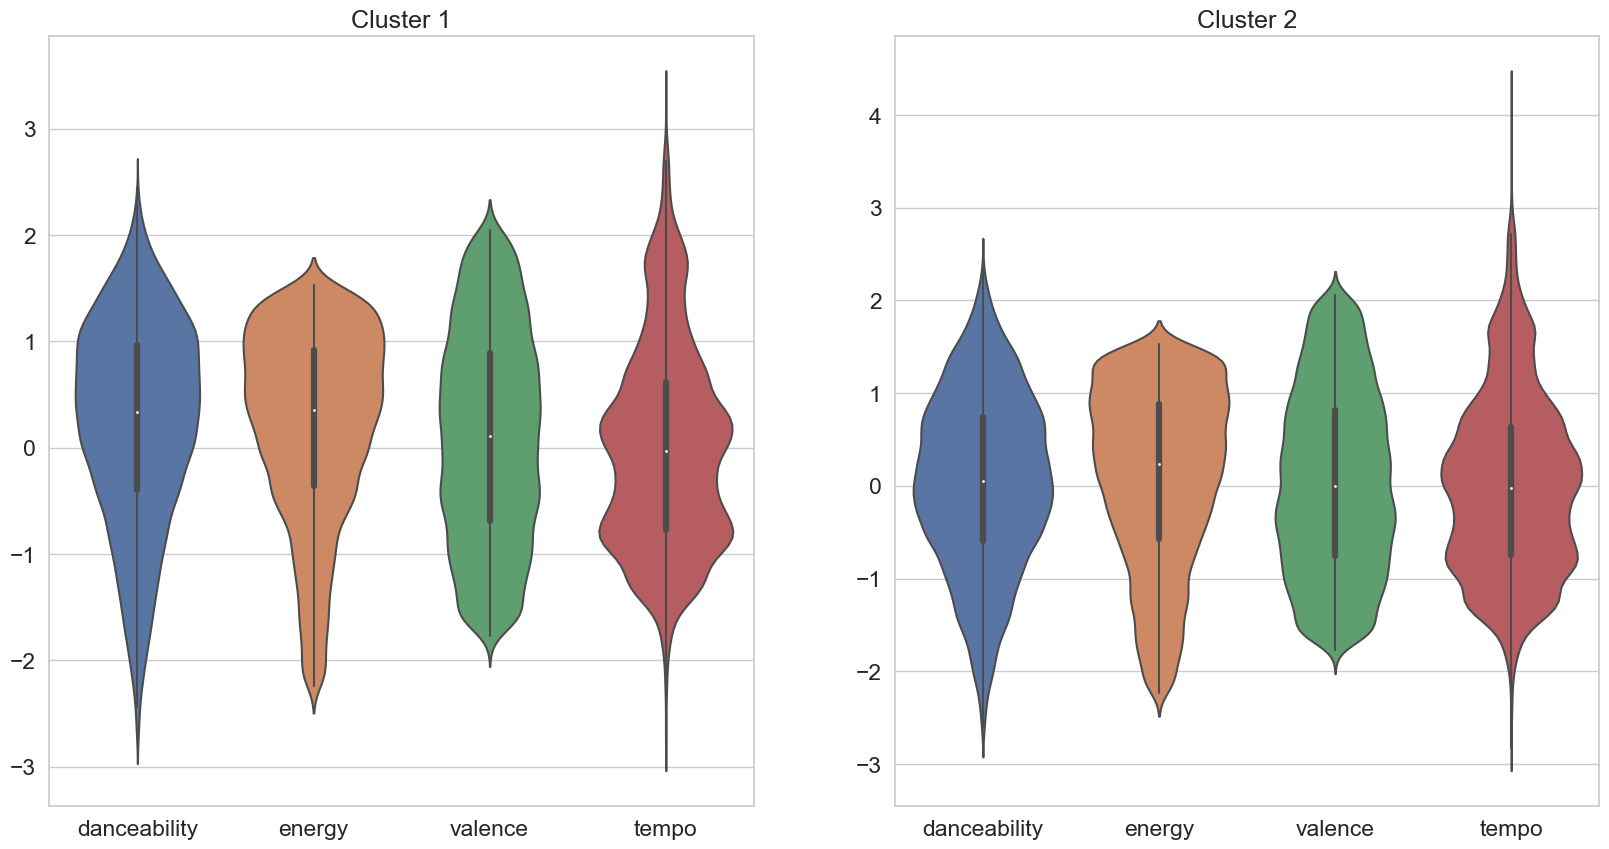

In [48]:
fig, axes = plt.subplots(1, 2, figsize = (20, 10))
sns.violinplot(ax = axes[0], data = temp_4[numeric_columns])
axes[0].title.set_text('Cluster 1')
sns.violinplot(ax = axes[1], data = temp_5[numeric_columns])
axes[1].title.set_text('Cluster 2')

In [49]:
cluster_1_mode_cnt = pd.DataFrame(temp_4.groupby(['mode']).count()['cluster'])
cluster_2_mode_cnt = pd.DataFrame(temp_5.groupby(['mode']).count()['cluster'])

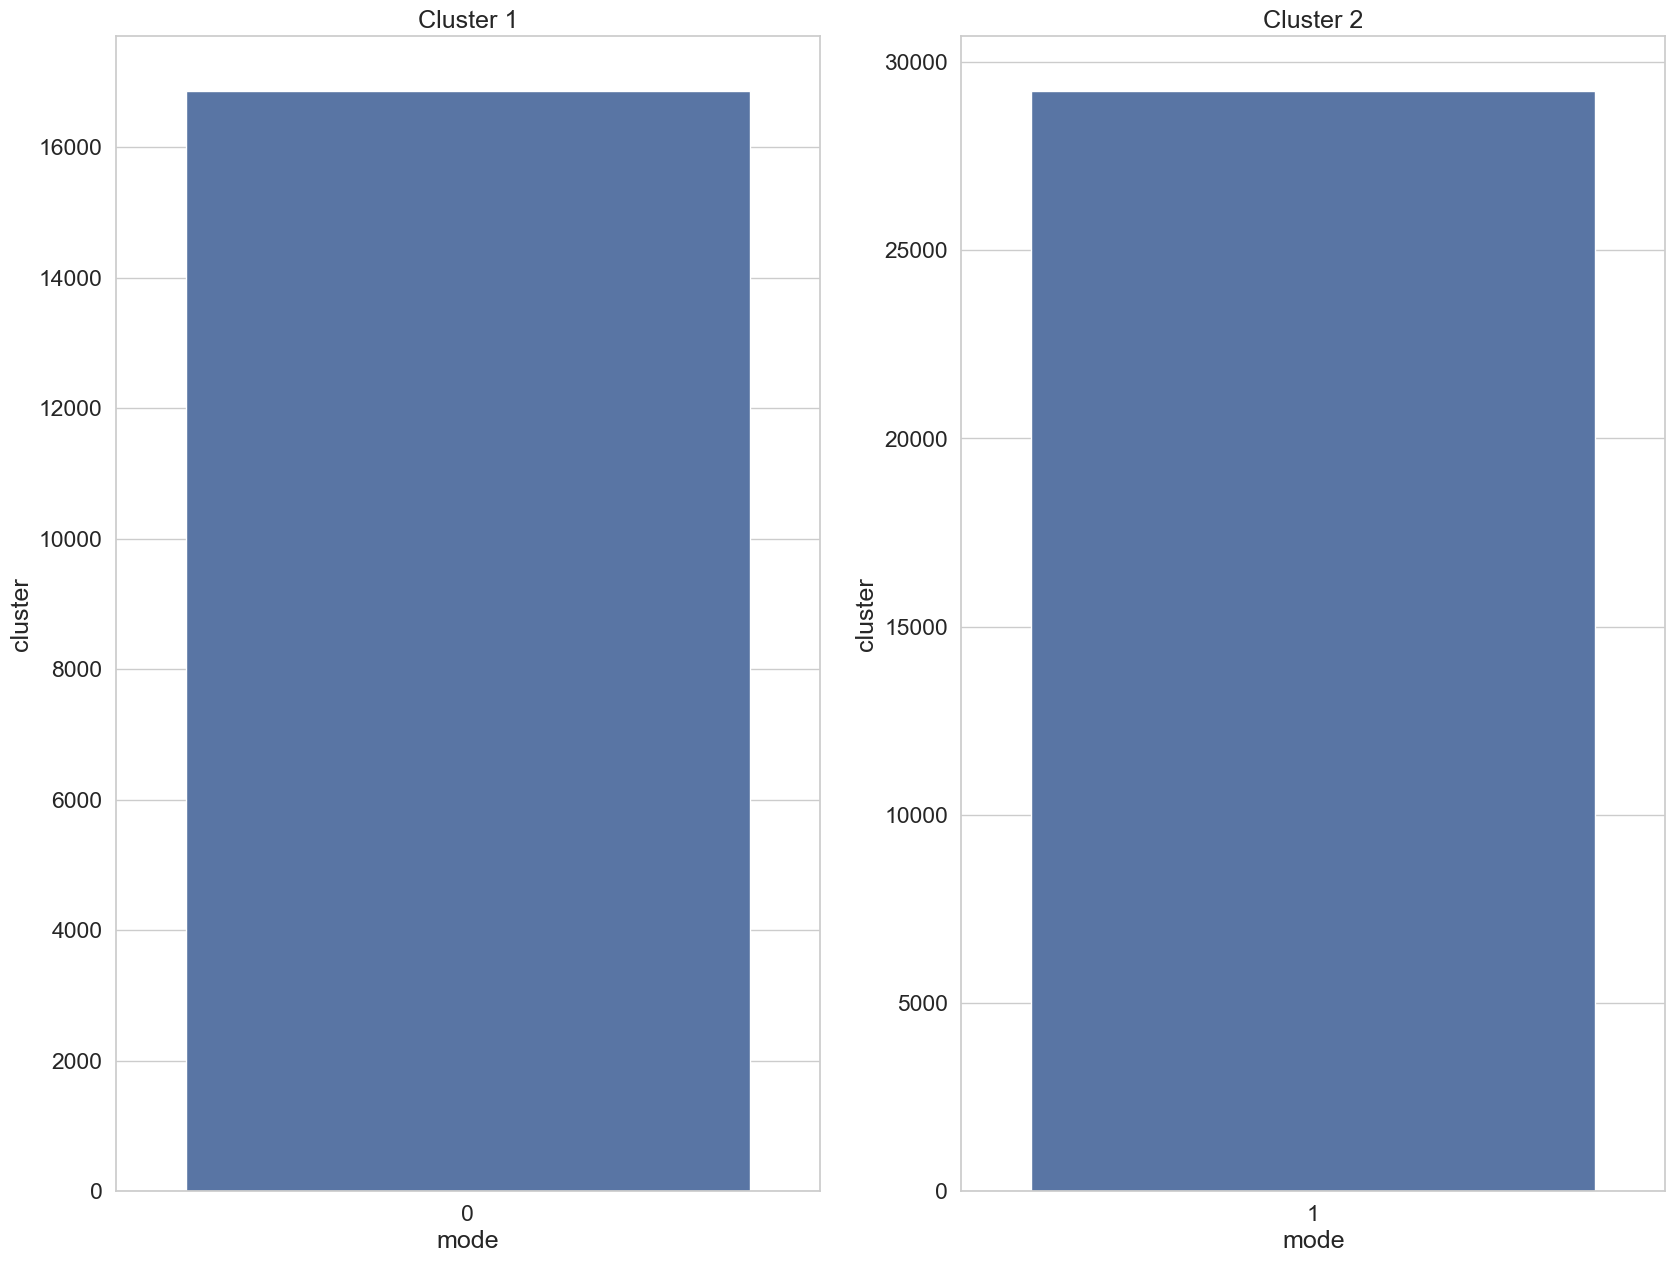

In [50]:
fig, axes = plt.subplots(1, 2, figsize = (20, 15))
sns.barplot(ax = axes[0], data = cluster_1_mode_cnt, x = cluster_1_mode_cnt.index, y = 'cluster')
axes[0].title.set_text('Cluster 1')
sns.barplot(ax = axes[1], data = cluster_2_mode_cnt, x = cluster_2_mode_cnt.index, y = 'cluster')
axes[1].title.set_text('Cluster 2')

## Previous Results (n = 4)

In [ ]:
gmm_model_4 = GaussianMixture(4, random_state = 2002, init_params = 'k-means++', n_init = 10)
labels = gmm_model_4.fit_predict(audio_features_ml)

In [ ]:
audio_features_ml['cluster'] = labels + 1
audio_features_ml['mode'] = audio_features['mode']
audio_features_ml.head()

In [ ]:
numeric_columns = list(audio_features_ml.columns[:4])
cluster_1 = audio_features_ml[audio_features_ml['cluster'] == 1]
cluster_2 = audio_features_ml[audio_features_ml['cluster'] == 2]
cluster_3 = audio_features_ml[audio_features_ml['cluster'] == 3]
cluster_4 = audio_features_ml[audio_features_ml['cluster'] == 4]

In [ ]:
cluster_1.head()

## Analysis of Clusters

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (20, 10))
sns.violinplot(ax = axes[0, 0], data = cluster_1[numeric_columns])
axes[0, 0].title.set_text('Cluster 1')
sns.violinplot(ax = axes[1, 0], data = cluster_2[numeric_columns])
axes[1, 0].title.set_text('Cluster 2')
sns.violinplot(ax = axes[0, 1], data = cluster_3[numeric_columns])
axes[0, 1].title.set_text('Cluster 3')
sns.violinplot(ax = axes[1, 1], data = cluster_4[numeric_columns])
axes[1, 1].title.set_text('Cluster 4')

In [ ]:
cluster_1_mode_cnt = pd.DataFrame(cluster_1.groupby(['mode']).count()['cluster'])
cluster_2_mode_cnt = pd.DataFrame(cluster_2.groupby(['mode']).count()['cluster'])
cluster_3_mode_cnt = pd.DataFrame(cluster_3.groupby(['mode']).count()['cluster'])
cluster_4_mode_cnt = pd.DataFrame(cluster_4.groupby(['mode']).count()['cluster'])

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))
sns.barplot(ax = axes[0, 0], data = cluster_1_mode_cnt, x = cluster_1_mode_cnt.index, y = 'cluster')
axes[0, 0].title.set_text('Cluster 1')
sns.barplot(ax = axes[1, 0], data = cluster_2_mode_cnt, x = cluster_2_mode_cnt.index, y = 'cluster')
axes[1, 0].title.set_text('Cluster 2')
sns.barplot(ax = axes[0, 1], data = cluster_3_mode_cnt, x = cluster_3_mode_cnt.index, y = 'cluster')
axes[0, 1].title.set_text('Cluster 3')
sns.barplot(ax = axes[1, 1], data = cluster_4_mode_cnt, x = cluster_4_mode_cnt.index, y = 'cluster')
axes[1, 1].title.set_text('Cluster 4')

If we use `reset_index()`, we can turn any indices into columns

In [ ]:
cluster_stats = audio_features_ml.groupby(['cluster']) \
    .describe()[numeric_columns]
cluster_stats = cluster_stats.T.reset_index()
cluster_stats = cluster_stats.rename(columns = {'level_0': 'feature', 'level_1': 'statistic'})
cluster_stats

In [ ]:
for feature in cluster_stats['feature'].unique():
    print(f'Feature: {feature}')
    temp = cluster_stats[cluster_stats['feature'] == feature]
    for i in range(1, 5):
        print(f'Cluster {i}')
        median = temp[temp['statistic'] == '50%'][i].iloc[0]
        iqr = temp[temp['statistic'] == '75%'][i].iloc[0] - temp[temp['statistic'] == '25%'][i].iloc[0]
        min = temp[temp['statistic'] == 'min'][i].iloc[0]
        max = temp[temp['statistic'] == 'max'][i].iloc[0]
        print(f'Median: {(median - min) / (max - min)}')
        print(f'IQR: {(iqr - min) / (max - min)}')
    print('')


In [ ]:
for i in range(1, 5):
    print(f'Cluster {i}')
    temp = cluster_stats.loc[:, :i]
    for feature in temp['feature'].unique():
        print(f'Feature: {feature}')
        temp_2 = temp[temp['feature'] == feature]
        median = temp_2[temp_2['statistic'] == '50%'][i].iloc[0]
        iqr = temp_2[temp_2['statistic'] == '75%'][i].iloc[0] - temp_2[temp_2['statistic'] == '25%'][i].iloc[0]
        min = temp_2[temp_2['statistic'] == 'min'][i].iloc[0]
        max = temp_2[temp_2['statistic'] == 'max'][i].iloc[0]
        print(f'Median: {(median - min) / (max - min)}')
        print(f'IQR: {(iqr - min) / (max - min)}')
    print('')

In [ ]:
audio_features.head()

In [ ]:
audio_features = audio_features.merge(audio_features_ml['cluster'], how = 'inner', left_index = True, right_index = True)

In [ ]:
audio_features.head()

In [ ]:
cluster_1_full = audio_features[audio_features['cluster'] == 1]
cluster_2_full = audio_features[audio_features['cluster'] == 2]
cluster_3_full = audio_features[audio_features['cluster'] == 3]
cluster_4_full = audio_features[audio_features['cluster'] == 4]

In [ ]:
cluster_1_full[cluster_1_full['genre'] == 'classical'].head()

In [ ]:
cluster_1_full[cluster_1_full['genre'] == 'ambient'].head()

In [ ]:
cluster_1_full[cluster_1_full['genre'] == 'jazz'].head()

In [ ]:
pd.DataFrame(audio_features.groupby(['cluster']).value_counts(['genre'])).T

## Analysis of Clusters

### Danceability
- 4 > 2 > 3 > 1 (Median)
- 3 > 1 > 4 > 2 (Variation)

### Energy
- 4 > 2 > 1 > 3 (Median)
- 3 > 2 > 1 > 4 (Variation)

### Valence
- 4 > 2 > 3 > 1 (Median)
- 3 > 4 > 2 > 1 (Variation)

### Tempo
- 3 > 4 > 1 > 2 (Median)
- 3 > 4 > 1 > 2 (Variation)



### Cluster 1
- Median tempo value is highest
- Tempo > Danceability > Energy > Valence

### Cluster 2
- Median energy value is highest
- Energy > Danceability > Valence > Tempo

### Cluster 3
- Median tempo value is highest
- Tempo > Danceability > Valence > Energy

### Cluster 4
- Median tempo value is highest
- Energy > Danceability > Valence > Tempo